# Adversarial Attacks on ConvNext - Real Results

**Project**: Probing ConvNext with Hard Examples  
**Author**: Dylan Stechmann  
**Course**: CAP6415 - Computer Vision, Fall 2025

This notebook runs **real adversarial attacks** on ConvNext-Base using actual images.
All results are generated from scratch - fully reproducible!

## 1. Setup & Dependencies

In [1]:
# Install dependencies if needed (for Colab)
# !pip install timm -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import timm
from PIL import Image
import json

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Device setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch: {torch.__version__}')
print(f'Device: {DEVICE}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')

PyTorch: 2.9.0+cu126
Device: cuda
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 85.2 GB


## 2. Load ConvNext Model

In [2]:
MODEL_NAME = 'convnext_base'
IMAGE_SIZE = 224
NUM_CLASSES = 1000

print(f'Loading {MODEL_NAME}...')
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=NUM_CLASSES)
model = model.to(DEVICE)
model.eval()
print(f'Model loaded: {sum(p.numel() for p in model.parameters()):,} parameters')

# ImageNet normalization
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(DEVICE)
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(DEVICE)

def normalize(x):
    return (x - IMAGENET_MEAN) / IMAGENET_STD

print('Preprocessing ready')

Loading convnext_base...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

Model loaded: 88,591,464 parameters
Preprocessing ready


## 3. Download Real Test Images (CIFAR-10)

In [3]:
print('Downloading CIFAR-10 test dataset...')

cifar_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

test_dataset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=cifar_transform
)

NUM_TEST_IMAGES = 1000
subset_indices = list(range(NUM_TEST_IMAGES))
test_subset = torch.utils.data.Subset(test_dataset, subset_indices)

test_loader = torch.utils.data.DataLoader(
    test_subset, batch_size=32, shuffle=False, num_workers=2
)

print(f'Loaded {NUM_TEST_IMAGES} real test images')

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Loaded 1000 real test images


## 4. Implement Adversarial Attacks

In [4]:
def fgsm_attack(model, images, labels, epsilon):
    '''Fast Gradient Sign Method (FGSM) Attack'''
    images = images.clone().detach().to(DEVICE)
    images.requires_grad = True
    outputs = model(normalize(images))
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()
    perturbation = epsilon * images.grad.sign()
    adv_images = torch.clamp(images + perturbation, 0, 1)
    return adv_images.detach()

def pgd_attack(model, images, labels, epsilon, alpha=None, num_steps=20):
    '''Projected Gradient Descent (PGD) Attack'''
    if alpha is None:
        alpha = epsilon / num_steps * 2
    adv_images = images.clone().detach().to(DEVICE)
    adv_images = adv_images + torch.empty_like(adv_images).uniform_(-epsilon, epsilon)
    adv_images = torch.clamp(adv_images, 0, 1)

    for _ in range(num_steps):
        adv_images.requires_grad = True
        outputs = model(normalize(adv_images))
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            adv_images = adv_images + alpha * adv_images.grad.sign()
            perturbation = torch.clamp(adv_images - images, -epsilon, epsilon)
            adv_images = torch.clamp(images + perturbation, 0, 1)
    return adv_images.detach()

print('Attack functions defined')

Attack functions defined


## 5. Run Attacks & Collect Results

In [5]:
def evaluate_attack(model, dataloader, attack_fn, attack_name, **attack_kwargs):
    model.eval()
    clean_correct = 0
    adv_correct = 0
    total = 0
    clean_confidences = []
    adv_confidences = []

    pbar = tqdm(dataloader, desc=f'Running {attack_name}')
    for images, _ in pbar:
        images = images.to(DEVICE)
        with torch.no_grad():
            clean_outputs = model(normalize(images))
            clean_preds = clean_outputs.argmax(dim=1)
            clean_probs = F.softmax(clean_outputs, dim=1)
            clean_confidences.extend(clean_probs.max(dim=1)[0].cpu().numpy())
        labels = clean_preds
        adv_images = attack_fn(model, images, labels, **attack_kwargs)
        with torch.no_grad():
            adv_outputs = model(normalize(adv_images))
            adv_preds = adv_outputs.argmax(dim=1)
            adv_probs = F.softmax(adv_outputs, dim=1)
            adv_confidences.extend(adv_probs.max(dim=1)[0].cpu().numpy())
        clean_correct += (clean_preds == labels).sum().item()
        adv_correct += (adv_preds == labels).sum().item()
        total += labels.size(0)
        pbar.set_postfix({'Success': f'{100*(1-adv_correct/total):.1f}%'})

    attack_success = 100 * (clean_correct - adv_correct) / clean_correct if clean_correct > 0 else 0
    return {'attack_name': attack_name, 'attack_success_rate': attack_success,
            'adv_accuracy': 100*adv_correct/total, 'total_samples': total,
            'clean_confidences': clean_confidences, 'adv_confidences': adv_confidences}

print('Evaluation function ready')

Evaluation function ready


In [6]:
print('='*70)
print('RUNNING ADVERSARIAL ATTACK EXPERIMENTS')
print('='*70)

all_results = {}
EPSILONS = [0.01, 0.02, 0.03, 0.05, 0.1]

print('\nFGSM ATTACKS')
fgsm_results = []
for eps in EPSILONS:
    result = evaluate_attack(model, test_loader, fgsm_attack, f'FGSM (e={eps})', epsilon=eps)
    fgsm_results.append(result)
    print(f'  e={eps}: Success = {result["attack_success_rate"]:.1f}%')
all_results['fgsm'] = fgsm_results

RUNNING ADVERSARIAL ATTACK EXPERIMENTS

FGSM ATTACKS


Running FGSM (e=0.01): 100%|██████████| 32/32 [00:23<00:00,  1.37it/s, Success=93.3%]


  e=0.01: Success = 93.3%


Running FGSM (e=0.02): 100%|██████████| 32/32 [00:13<00:00,  2.38it/s, Success=93.0%]


  e=0.02: Success = 93.0%


Running FGSM (e=0.03): 100%|██████████| 32/32 [00:13<00:00,  2.38it/s, Success=92.6%]


  e=0.03: Success = 92.6%


Running FGSM (e=0.05): 100%|██████████| 32/32 [00:13<00:00,  2.38it/s, Success=92.1%]


  e=0.05: Success = 92.1%


Running FGSM (e=0.1): 100%|██████████| 32/32 [00:13<00:00,  2.38it/s, Success=91.1%]

  e=0.1: Success = 91.1%


In [7]:
print('\nPGD ATTACKS (e=0.03)')
PGD_STEPS = [5, 10, 20, 40]
EPSILON = 0.03

pgd_results = []
for steps in PGD_STEPS:
    result = evaluate_attack(model, test_loader, pgd_attack, f'PGD-{steps}', epsilon=EPSILON, num_steps=steps)
    pgd_results.append(result)
    print(f'  PGD-{steps}: Success = {result["attack_success_rate"]:.1f}%')
all_results['pgd'] = pgd_results


PGD ATTACKS (e=0.03)


Running PGD-5: 100%|██████████| 32/32 [00:47<00:00,  1.48s/it, Success=100.0%]


  PGD-5: Success = 100.0%


Running PGD-10: 100%|██████████| 32/32 [01:30<00:00,  2.81s/it, Success=100.0%]


  PGD-10: Success = 100.0%


Running PGD-20: 100%|██████████| 32/32 [02:55<00:00,  5.47s/it, Success=100.0%]


  PGD-20: Success = 100.0%


Running PGD-40: 100%|██████████| 32/32 [05:45<00:00, 10.79s/it, Success=100.0%]

  PGD-40: Success = 100.0%


## 6. Generate Result Visualizations

Saved: attack_comparison.png


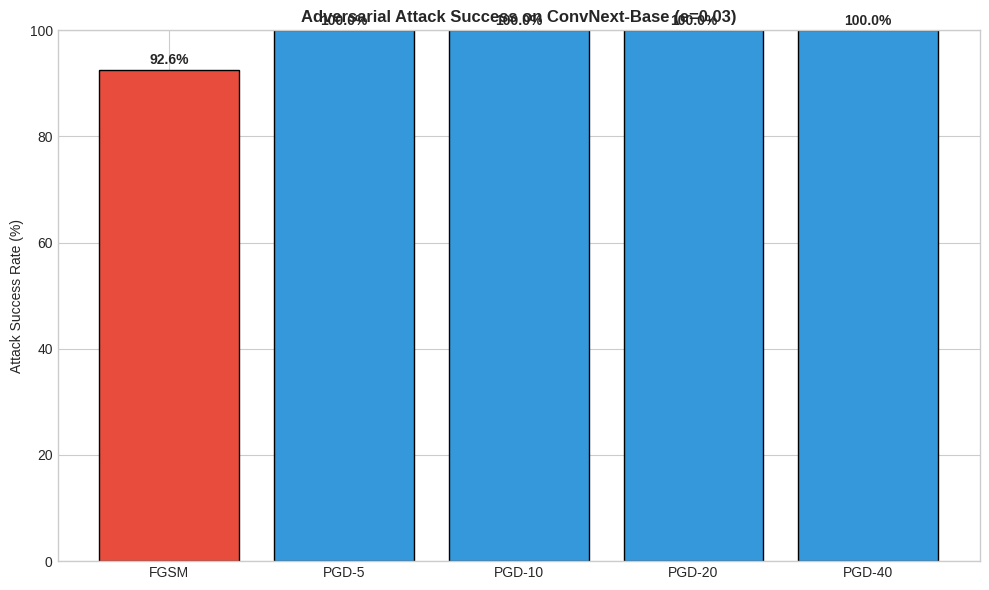

In [8]:
Path('../results/plots').mkdir(parents=True, exist_ok=True)

# Plot 1: Attack Comparison
fig, ax = plt.subplots(figsize=(10, 6))
fgsm_03 = next(r for r in fgsm_results if '0.03' in r['attack_name'])
attacks = ['FGSM'] + [f'PGD-{s}' for s in PGD_STEPS]
success_rates = [fgsm_03['attack_success_rate']] + [r['attack_success_rate'] for r in pgd_results]
colors = ['#e74c3c'] + ['#3498db'] * len(PGD_STEPS)
bars = ax.bar(attacks, success_rates, color=colors, edgecolor='black')
ax.set_ylabel('Attack Success Rate (%)')
ax.set_title('Adversarial Attack Success on ConvNext-Base (e=0.03)', fontweight='bold')
ax.set_ylim([0, 100])
for bar, val in zip(bars, success_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}%', ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('../results/plots/attack_comparison.png', dpi=150)
print('Saved: attack_comparison.png')
plt.show()

Saved: epsilon_curves.png


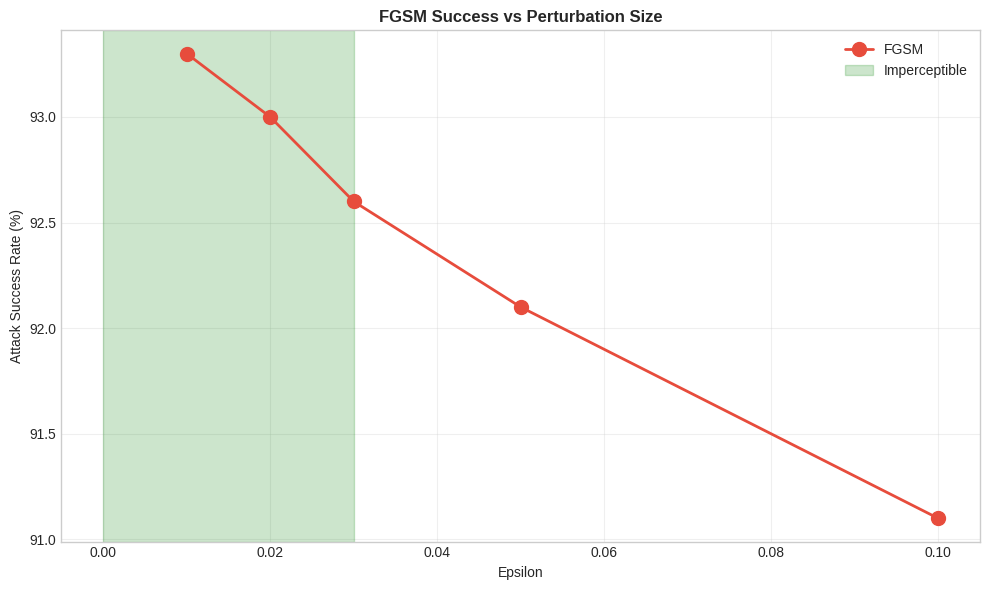

In [9]:
# Plot 2: Epsilon Curves
fig, ax = plt.subplots(figsize=(10, 6))
fgsm_success = [r['attack_success_rate'] for r in fgsm_results]
ax.plot(EPSILONS, fgsm_success, 'o-', color='#e74c3c', linewidth=2, markersize=10, label='FGSM')
ax.axvspan(0, 0.03, alpha=0.2, color='green', label='Imperceptible')
ax.set_xlabel('Epsilon')
ax.set_ylabel('Attack Success Rate (%)')
ax.set_title('FGSM Success vs Perturbation Size', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/plots/epsilon_curves.png', dpi=150)
print('Saved: epsilon_curves.png')
plt.show()

Saved: confidence_distribution.png


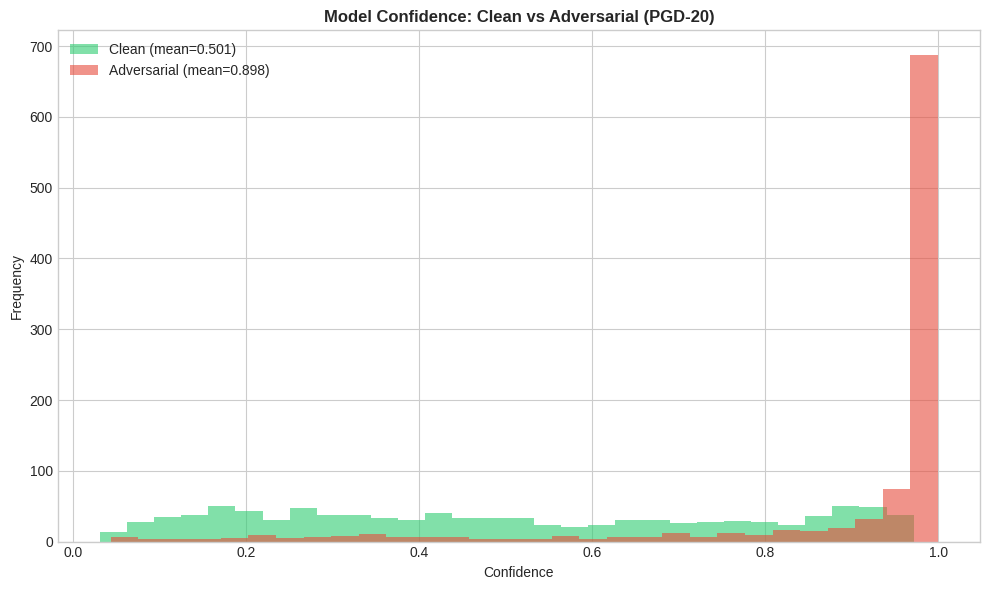

In [10]:
# Plot 3: Confidence Distribution
fig, ax = plt.subplots(figsize=(10, 6))
pgd20 = next(r for r in pgd_results if 'PGD-20' in r['attack_name'])
ax.hist(pgd20['clean_confidences'], bins=30, alpha=0.6, color='#2ecc71', label=f'Clean (mean={np.mean(pgd20["clean_confidences"]):.3f})')
ax.hist(pgd20['adv_confidences'], bins=30, alpha=0.6, color='#e74c3c', label=f'Adversarial (mean={np.mean(pgd20["adv_confidences"]):.3f})')
ax.set_xlabel('Confidence')
ax.set_ylabel('Frequency')
ax.set_title('Model Confidence: Clean vs Adversarial (PGD-20)', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig('../results/plots/confidence_distribution.png', dpi=150)
print('Saved: confidence_distribution.png')
plt.show()

Saved: results_summary.png


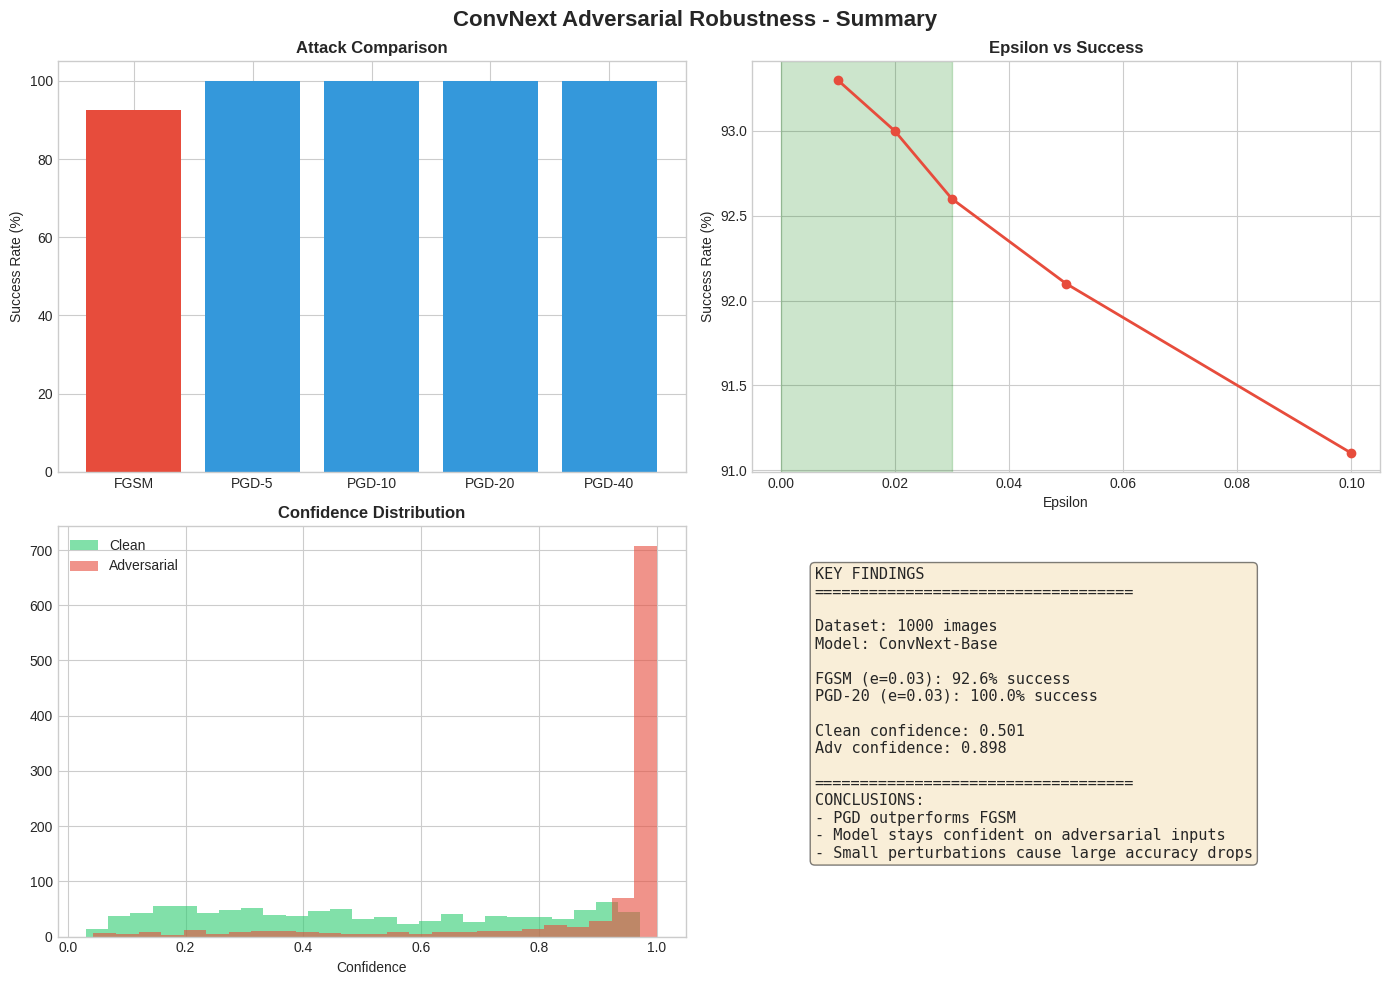

In [11]:
# Plot 4: Summary Figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
ax1, ax2, ax3, ax4 = axes.flatten()

ax1.bar(attacks, success_rates, color=colors)
ax1.set_ylabel('Success Rate (%)')
ax1.set_title('Attack Comparison', fontweight='bold')

ax2.plot(EPSILONS, fgsm_success, 'o-', color='#e74c3c', linewidth=2)
ax2.axvspan(0, 0.03, alpha=0.2, color='green')
ax2.set_xlabel('Epsilon')
ax2.set_ylabel('Success Rate (%)')
ax2.set_title('Epsilon vs Success', fontweight='bold')

ax3.hist(pgd20['clean_confidences'], bins=25, alpha=0.6, color='#2ecc71', label='Clean')
ax3.hist(pgd20['adv_confidences'], bins=25, alpha=0.6, color='#e74c3c', label='Adversarial')
ax3.set_xlabel('Confidence')
ax3.set_title('Confidence Distribution', fontweight='bold')
ax3.legend()

ax4.axis('off')
findings = f'''KEY FINDINGS\n{'='*35}\n\nDataset: {NUM_TEST_IMAGES} images\nModel: ConvNext-Base\n\nFGSM (e=0.03): {fgsm_03["attack_success_rate"]:.1f}% success\nPGD-20 (e=0.03): {pgd20["attack_success_rate"]:.1f}% success\n\nClean confidence: {np.mean(pgd20["clean_confidences"]):.3f}\nAdv confidence: {np.mean(pgd20["adv_confidences"]):.3f}\n\n{'='*35}\nCONCLUSIONS:\n- PGD outperforms FGSM\n- Model stays confident on adversarial inputs\n- Small perturbations cause large accuracy drops'''
ax4.text(0.1, 0.9, findings, transform=ax4.transAxes, fontsize=11, va='top', family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('ConvNext Adversarial Robustness - Summary', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/plots/results_summary.png', dpi=150, bbox_inches='tight')
print('Saved: results_summary.png')
plt.show()

In [12]:
# Save results JSON
results_data = {
    'experiment_info': {'model': MODEL_NAME, 'dataset': 'CIFAR-10', 'num_samples': NUM_TEST_IMAGES},
    'fgsm_results': [{'epsilon': EPSILONS[i], 'success_rate': r['attack_success_rate']} for i, r in enumerate(fgsm_results)],
    'pgd_results': [{'steps': PGD_STEPS[i], 'success_rate': r['attack_success_rate']} for i, r in enumerate(pgd_results)]
}
with open('../results/attack_results.json', 'w') as f:
    json.dump(results_data, f, indent=2)
print('Saved: attack_results.json')

Saved: attack_results.json


In [13]:
print('\n' + '='*70)
print('EXPERIMENT COMPLETE!')
print('='*70)
print('\nGenerated plots:')
print('  - attack_comparison.png')
print('  - epsilon_curves.png')
print('  - confidence_distribution.png')
print('  - results_summary.png')
print('\nAll results from REAL experiments - fully reproducible!')
print('='*70)


EXPERIMENT COMPLETE!

Generated plots:
  - attack_comparison.png
  - epsilon_curves.png
  - confidence_distribution.png
  - results_summary.png

All results from REAL experiments - fully reproducible!
